<a href="https://colab.research.google.com/github/saadan1234/Optical-Network-and-Technologies/blob/main/T5KnowledgeDistillation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Notebook Overview

1. Import EU Dataset
2. Train Teacher Model on EU Dataset
3. Knowledge Distillation - Hard Distillation on EU Dataset
4. Knowledge Distillation - Soft Distillation on EU Dataset
5. Time and Memory Comparison Analysis on EU Dataset
6. Import USA Dataset
7. Train Teacher Model on USA Dataset
8. Knowledge Distillation - Hard Distillation on USA Dataset
9. Knowledge Distillation - Soft Distillation on USA Dataset
10. Time and Memory Comparison Analysis on USA Dataset

# Importing Libraries

In [1]:
pip install memory-profiler


In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
from sklearn.utils import resample
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import pearsonr
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.optimizers import Adam
import time
from memory_profiler import memory_usage
import psutil
import os


# EU Data Import

In [3]:
# Import the drive module from google.colab
from google.colab import drive

# Mount Google Drive to the specified folder (/content/drive)
# This allows access to files stored in your Google Drive from the Colab environment
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
# Define the file path for the Excel file stored in Google Drive
file_path = '/content/drive/MyDrive/DataSet_EU_3k_5k.xlsx'

# Use pandas to read the Excel file located at the specified file path
data = pd.read_excel(file_path)

In [5]:
# Display the first few rows of the dataframe to get an overview of the data
data.head()

,Power_1,Power_2,Power_3,Power_4,Power_5,Power_6,Power_7,Power_8,Power_9,Power_10,...,GSNR_69,GSNR_70,GSNR_71,GSNR_72,GSNR_73,GSNR_74,GSNR_75,GSNR_76,No. Spans,Total Distance(m)
0,0.000000,0.000000,0.000007,0.000007,0.000007,0.000000,0.000007,0.0,0.000007,0.0,...,90.061284,0.000000,0.000000,0.000000,0.000000,95.045789,0.000000,0.000000,8,690608.0
1,0.000000,0.000007,0.000000,0.000007,0.000000,0.000007,0.000000,0.0,0.000000,0.0,...,0.000000,92.560867,0.000000,0.000000,89.544975,0.000000,0.000000,0.000000,8,690608.0
2,0.000000,0.000000,0.000000,0.000007,0.000000,0.000000,0.000000,0.0,0.000007,0.0,...,0.000000,0.000000,90.991977,0.000000,0.000000,0.000000,85.512399,83.114113,8,690608.0
3,0.000007,0.000007,0.000007,0.000007,0.000007,0.000000,0.000000,0.0,0.000007,0.0,...,76.409583,73.664915,74.651700,79.071217,0.000000,0.000000,0.000000,0.000000,8,690608.0
4,0.000000,0.000000,0.000007,0.000000,0.000007,0.000000,0.000000,0.0,0.000007,0.0,...,0.000000,0.000000,78.299438,74.910765,72.030907,73.790264,81.190439,0.000000,8,690608.0


# Data Preparation

In [6]:
# Define the attribute columns and the target variable
attribute_columns = [f'Power_{i}' for i in range(1, 77)] + [f'ASE_{i}' for i in range(1, 77)] + [f'NLI_{i}' for i in range(1, 77)]+ ['No. Spans'] + ['Total Distance(m)']

# Label
target_column = 'GSNR_1'

Frequency is not included in the above data as it is proven to have no correlation with the label in the previous tasks.

### Normalization

In [7]:
# MinMax Normalization
# Initialize the MinMaxScaler
scaler = MinMaxScaler()

# Normalize the attribute columns using MinMaxScaler and convert the result back to a DataFrame
x = scaler.fit_transform(data[attribute_columns])
x = pd.DataFrame(x, columns=attribute_columns)

# Extract the target variable values and reshape them for normalization
y = data[target_column].values.reshape(-1, 1)
# Normalize the target variable using MinMaxScaler and convert the result back to a DataFrame
y = scaler.fit_transform(y)
y = pd.DataFrame(y, columns=[target_column])

# Display the first few rows of the normalized data for selected columns
print("MinMax Normalized Data:")
print(x['Power_1'].head(), x['ASE_1'].head(), x['NLI_1'].head(), x['No. Spans'].head(), x['Total Distance(m)'].head())
print(y.head())

MinMax Normalized Data:
0    0.000000
1    0.000000
2    0.000000
3    0.076798
4    0.000000
Name: Power_1, dtype: float64 0    0.075117
1    0.073203
2    0.073788
3    0.000062
4    0.071547
Name: ASE_1, dtype: float64 0    0.000000
1    0.000000
2    0.000000
3    0.017928
4    0.000000
Name: NLI_1, dtype: float64 0    0.037037
1    0.037037
2    0.037037
3    0.037037
4    0.037037
Name: No. Spans, dtype: float64 0    0.008849
1    0.008849
2    0.008849
3    0.008849
4    0.008849
Name: Total Distance(m), dtype: float64
    GSNR_1
0  0.00000
1  0.00000
2  0.00000
3  0.79791
4  0.00000


### Path Wise Split

In [8]:
# Define the function to split data according to the specified pattern
def custom_train_test_split(data, labels, samples_per_block=3000, train_samples_per_block=2500, test_samples_per_block=500):
    # Initialize lists to hold the training and testing data and labels
    train_data = []
    test_data = []
    train_labels = []
    test_labels = []

    # Determine the total number of samples in the data
    total_samples = len(data)

    # Loop over the data in blocks of the specified size (samples_per_block)
    for start in range(0, total_samples, samples_per_block):
        # Define the end of the current block
        end = start + samples_per_block
        # Define the end of the training samples within the current block
        train_end = start + train_samples_per_block

        # Adjust train_end and end if they exceed the total number of samples
        if train_end > total_samples:
            train_end = total_samples
        if end > total_samples:
            end = total_samples

        # Append the training and testing data and labels for the current block to the respective lists
        train_data.append(data[start:train_end])
        test_data.append(data[train_end:end])
        train_labels.append(labels[start:train_end])
        test_labels.append(labels[train_end:end])

    # Concatenate the lists into DataFrames and reset the index
    train_data = pd.concat(train_data).reset_index(drop=True)
    test_data = pd.concat(test_data).reset_index(drop=True)
    train_labels = pd.concat(train_labels).reset_index(drop=True)
    test_labels = pd.concat(test_labels).reset_index(drop=True)

    # Return the training and testing data and labels
    return train_data, test_data, train_labels, test_labels

# Create a list of attribute columns excluding those that start with 'frequency'
attribute_columns_without_frequency = [col for col in attribute_columns if not col.startswith('frequency')]

# Assuming 'x' and 'y' are your DataFrames for MinMax normalized data
# Perform the custom train-test split on the normalized data
X_train, X_test, Y_train, Y_test = custom_train_test_split(x[attribute_columns_without_frequency], y[target_column])

# Display shapes to verify the split
print("Normalized data with equal path distribution in train and test data :\n")
print("Train data shape:", X_train.shape)
print("Test data shape:", X_test.shape)
print("Train labels shape:", Y_train.shape)
print("Test labels shape:", Y_test.shape)

Normalized data with equal path distribution in train and test data :

Train data shape: (15000, 230)
Test data shape: (3000, 230)
Train labels shape: (15000,)
Test labels shape: (3000,)


# Teacher Model

In [9]:
# Define a large teacher model architecture
teacher_model = Sequential([
    Dense(256, activation='relu', input_shape=(len(attribute_columns),)),  # First layer with 256 neurons
    Dropout(0.2),  # Add dropout for regularization
    Dense(128, activation='relu'),  # Second layer with 128 neurons
    Dropout(0.2),  # Add dropout for regularization
    Dense(64, activation='relu'),  # Third layer with 64 neurons
    Dropout(0.2),  # Add dropout for regularization
    Dense(32, activation='relu'),  # Fourth layer with 32 neurons
    Dense(16, activation='relu'),  # Fifth layer with 16 neurons
    Dense(1)  # Output layer for regression task
])

# Compile the model
teacher_model.compile(optimizer='adam', loss='mse', metrics=['mae'])

# Train the teacher model
history = teacher_model.fit(X_train, Y_train, epochs=25, batch_size=64, validation_split=0.2)  # Increase epochs for better training

# Evaluate the teacher model
val_loss, val_mae = teacher_model.evaluate(X_test, Y_test)
print(f"Validation MAE: {val_mae}")


Epoch 1/25
188/188 [==============================] - 4s 9ms/step - loss: 0.0443 - mae: 0.1358 - val_loss: 0.0068 - val_mae: 0.0669
Epoch 2/25
188/188 [==============================] - 1s 6ms/step - loss: 0.0042 - mae: 0.0453 - val_loss: 0.0012 - val_mae: 0.0255
Epoch 3/25
188/188 [==============================] - 1s 6ms/step - loss: 0.0018 - mae: 0.0256 - val_loss: 0.0014 - val_mae: 0.0229
Epoch 4/25
188/188 [==============================] - 1s 6ms/step - loss: 0.0012 - mae: 0.0199 - val_loss: 0.0016 - val_mae: 0.0221
Epoch 5/25
188/188 [==============================] - 1s 6ms/step - loss: 8.6152e-04 - mae: 0.0167 - val_loss: 9.5381e-04 - val_mae: 0.0181
Epoch 6/25
188/188 [==============================] - 1s 6ms/step - loss: 6.3518e-04 - mae: 0.0139 - val_loss: 0.0015 - val_mae: 0.0249
Epoch 7/25
188/188 [==============================] - 1s 6ms/step - loss: 5.4001e-04 - mae: 0.0123 - val_loss: 0.0017 - val_mae: 0.0239
Epoch 8/25
188/188 [==============================] - 1s 6ms

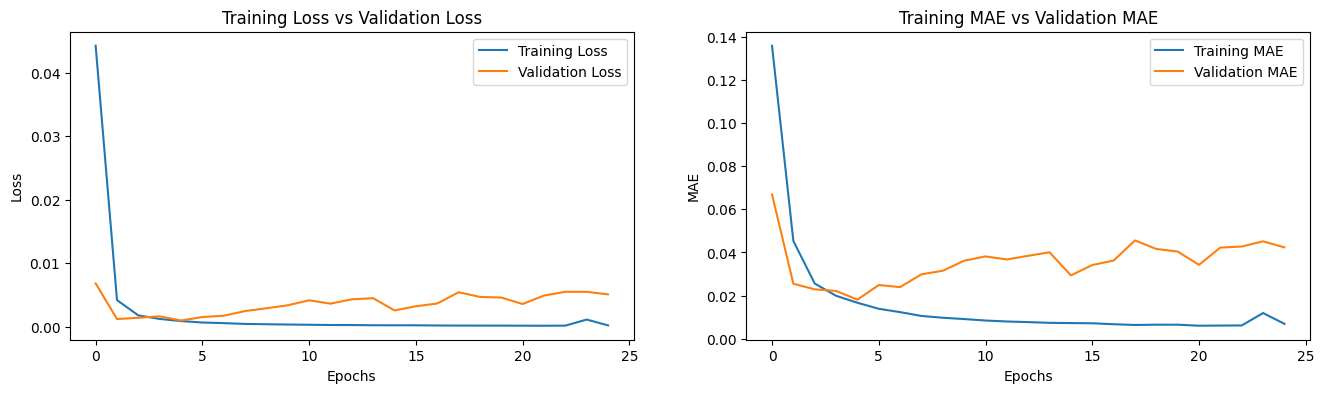

In [10]:
# Plot the training loss vs validation loss
plt.figure(figsize=(16, 4))

# Plot loss
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training Loss vs Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

# Plot MAE
plt.subplot(1, 2, 2)
plt.plot(history.history['mae'], label='Training MAE')
plt.plot(history.history['val_mae'], label='Validation MAE')
plt.title('Training MAE vs Validation MAE')
plt.xlabel('Epochs')
plt.ylabel('MAE')
plt.legend()

plt.show()


# Student Model

### Hard Distillation

In [11]:
# Define the student model architecture
student_model_hard = Sequential([
    Dense(64, activation='relu', input_shape=(len(attribute_columns),)),
    Dropout(0.2),
    Dense(32, activation='relu'),
    Dropout(0.2),
    Dense(1)
])

# Compile the student model
student_model_hard.compile(optimizer='adam', loss='mse', metrics=['mae'])

# Train the student model
history_hard = student_model_hard.fit(X_train, Y_train, epochs=25, batch_size=64, validation_split=0.2)  # Increase epochs for better training

# Evaluate the student model
val_loss_hard, val_mae_hard = student_model_hard.evaluate(X_test, Y_test)
print(f"Validation MAE (Hard Distillation): {val_mae_hard}")


Epoch 1/25
188/188 [==============================] - 2s 6ms/step - loss: 0.0691 - mae: 0.1796 - val_loss: 0.0880 - val_mae: 0.2731
Epoch 2/25
188/188 [==============================] - 1s 4ms/step - loss: 0.0343 - mae: 0.1321 - val_loss: 0.0243 - val_mae: 0.1433
Epoch 3/25
188/188 [==============================] - 1s 4ms/step - loss: 0.0141 - mae: 0.0839 - val_loss: 0.0023 - val_mae: 0.0412
Epoch 4/25
188/188 [==============================] - 1s 4ms/step - loss: 0.0066 - mae: 0.0564 - val_loss: 0.0015 - val_mae: 0.0293
Epoch 5/25
188/188 [==============================] - 1s 4ms/step - loss: 0.0048 - mae: 0.0451 - val_loss: 0.0012 - val_mae: 0.0227
Epoch 6/25
188/188 [==============================] - 1s 4ms/step - loss: 0.0041 - mae: 0.0391 - val_loss: 0.0015 - val_mae: 0.0236
Epoch 7/25
188/188 [==============================] - 1s 4ms/step - loss: 0.0034 - mae: 0.0349 - val_loss: 0.0022 - val_mae: 0.0276
Epoch 8/25
188/188 [==============================] - 1s 3ms/step - loss: 0.

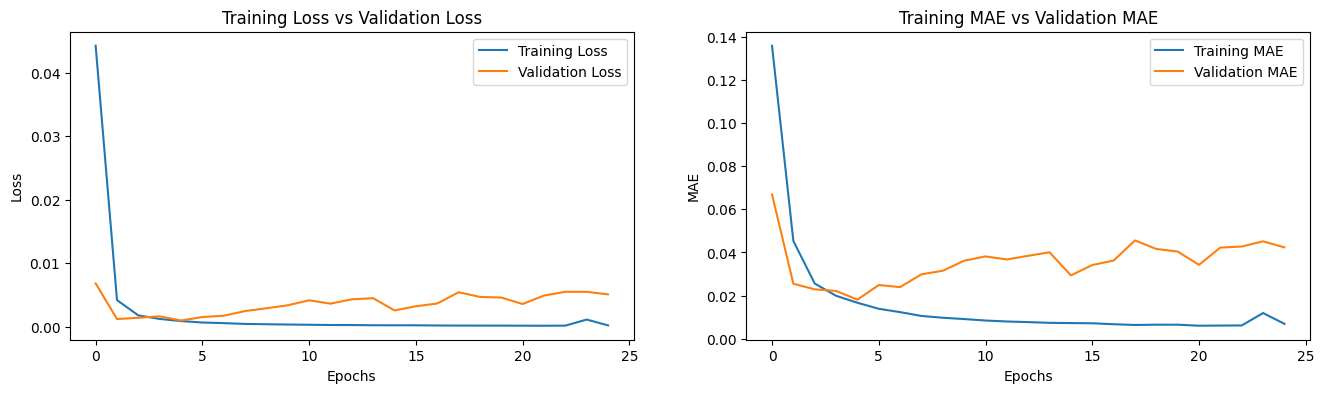

In [12]:
# Plot the training loss vs validation loss
plt.figure(figsize=(16, 4))

# Plot loss
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training Loss vs Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

# Plot MAE
plt.subplot(1, 2, 2)
plt.plot(history.history['mae'], label='Training MAE')
plt.plot(history.history['val_mae'], label='Validation MAE')
plt.title('Training MAE vs Validation MAE')
plt.xlabel('Epochs')
plt.ylabel('MAE')
plt.legend()

plt.show()


### Soft Distilaltion

In [13]:
def get_softened_outputs(model, data, temperature=1):
    logits = model.predict(data) / temperature
    exp_logits = np.exp(logits)
    return exp_logits / np.sum(exp_logits, axis=1, keepdims=True)

In [14]:
# Get softened outputs from the teacher model
temperature = 1
soft_targets = get_softened_outputs(teacher_model, X_train, temperature)

# Define the student model architecture
student_model_soft = Sequential([
    Dense(64, activation='relu', input_shape=(len(attribute_columns),)),
    Dropout(0.2),
    Dense(32, activation='relu'),
    Dropout(0.2),
    Dense(1)
])

# Compile the student model
student_model_soft.compile(optimizer='adam', loss='mse', metrics=['mae'])

# Train the student model using a combination of soft targets and ground truth labels
Y_train = Y_train.values.reshape(-1, 1)
y_combined = 0.5 * Y_train + 0.5 * soft_targets

history_soft = student_model_soft.fit(X_train, y_combined, epochs=25, batch_size=64, validation_split=0.2)  # Increase epochs for better training


# Evaluate the student model
val_loss_soft, val_mae_soft = student_model_soft.evaluate(X_test, Y_test)
print(f"Validation MAE (Soft Distillation): {val_mae_soft}")


469/469 [==============================] - 1s 2ms/step
Epoch 1/25
188/188 [==============================] - 2s 4ms/step - loss: 0.0642 - mae: 0.1884 - val_loss: 0.0225 - val_mae: 0.1393
Epoch 2/25
188/188 [==============================] - 1s 3ms/step - loss: 0.0190 - mae: 0.1086 - val_loss: 0.0161 - val_mae: 0.1164
Epoch 3/25
188/188 [==============================] - 1s 3ms/step - loss: 0.0133 - mae: 0.0892 - val_loss: 0.0103 - val_mae: 0.0906
Epoch 4/25
188/188 [==============================] - 1s 3ms/step - loss: 0.0092 - mae: 0.0734 - val_loss: 0.0066 - val_mae: 0.0597
Epoch 5/25
188/188 [==============================] - 1s 3ms/step - loss: 0.0060 - mae: 0.0594 - val_loss: 0.0029 - val_mae: 0.0413
Epoch 6/25
188/188 [==============================] - 1s 3ms/step - loss: 0.0042 - mae: 0.0488 - val_loss: 0.0025 - val_mae: 0.0381
Epoch 7/25
188/188 [==============================] - 1s 3ms/step - loss: 0.0032 - mae: 0.0424 - val_loss: 0.0045 - val_mae: 0.0504
Epoch 8/25
188/188 [=

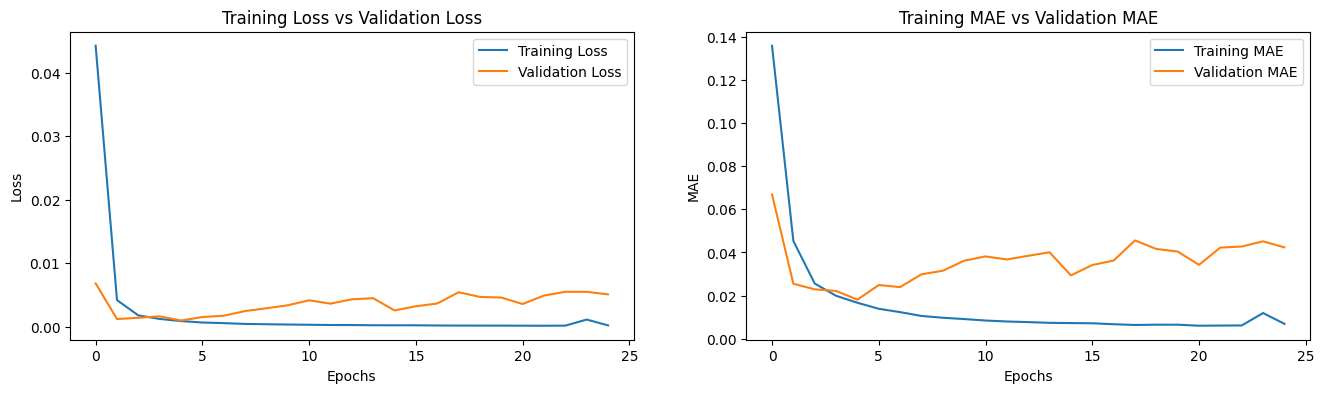

In [15]:
# Plot the training loss vs validation loss
plt.figure(figsize=(16, 4))

# Plot loss
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training Loss vs Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

# Plot MAE
plt.subplot(1, 2, 2)
plt.plot(history.history['mae'], label='Training MAE')
plt.plot(history.history['val_mae'], label='Validation MAE')
plt.title('Training MAE vs Validation MAE')
plt.xlabel('Epochs')
plt.ylabel('MAE')
plt.legend()

plt.show()


In [16]:
# Get softened outputs from the teacher model
temperature = 5
soft_targets = get_softened_outputs(teacher_model, X_train, temperature)

# Define the student model architecture
student_model_soft = Sequential([
    Dense(64, activation='relu', input_shape=(len(attribute_columns),)),
    Dropout(0.2),
    Dense(32, activation='relu'),
    Dropout(0.2),
    Dense(1)
])

# Compile the student model
student_model_soft.compile(optimizer='adam', loss='mse', metrics=['mae'])

# Train the student model using a combination of soft targets and ground truth labels
Y_train = Y_train.reshape(-1, 1)
y_combined = 0.5 * Y_train + 0.5 * soft_targets

history_soft = student_model_soft.fit(X_train, y_combined, epochs=25, batch_size=64, validation_split=0.2)  # Increase epochs for better training


# Evaluate the student model
val_loss_soft, val_mae_soft = student_model_soft.evaluate(X_test, Y_test)
print(f"Validation MAE (Soft Distillation): {val_mae_soft}")


469/469 [==============================] - 1s 3ms/step
Epoch 1/25
188/188 [==============================] - 1s 3ms/step - loss: 0.1008 - mae: 0.2355 - val_loss: 0.0271 - val_mae: 0.1445
Epoch 2/25
188/188 [==============================] - 1s 3ms/step - loss: 0.0202 - mae: 0.1088 - val_loss: 0.0229 - val_mae: 0.1334
Epoch 3/25
188/188 [==============================] - 0s 2ms/step - loss: 0.0152 - mae: 0.0935 - val_loss: 0.0191 - val_mae: 0.1197
Epoch 4/25
188/188 [==============================] - 1s 3ms/step - loss: 0.0127 - mae: 0.0849 - val_loss: 0.0134 - val_mae: 0.0993
Epoch 5/25
188/188 [==============================] - 0s 2ms/step - loss: 0.0103 - mae: 0.0764 - val_loss: 0.0074 - val_mae: 0.0768
Epoch 6/25
188/188 [==============================] - 1s 3ms/step - loss: 0.0080 - mae: 0.0670 - val_loss: 0.0040 - val_mae: 0.0545
Epoch 7/25
188/188 [==============================] - 0s 3ms/step - loss: 0.0065 - mae: 0.0601 - val_loss: 0.0012 - val_mae: 0.0300
Epoch 8/25
188/188 [=

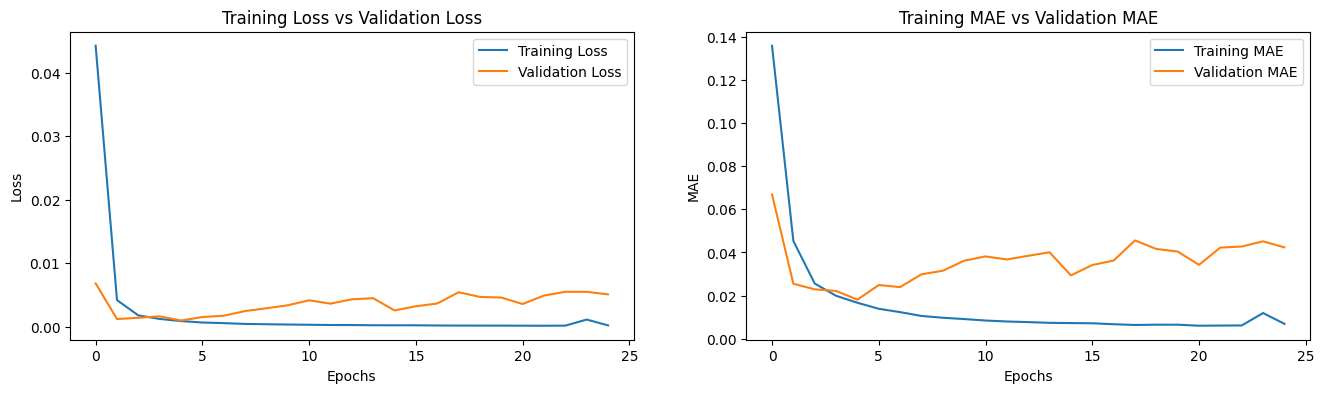

In [17]:
# Plot the training loss vs validation loss
plt.figure(figsize=(16, 4))

# Plot loss
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training Loss vs Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

# Plot MAE
plt.subplot(1, 2, 2)
plt.plot(history.history['mae'], label='Training MAE')
plt.plot(history.history['val_mae'], label='Validation MAE')
plt.title('Training MAE vs Validation MAE')
plt.xlabel('Epochs')
plt.ylabel('MAE')
plt.legend()

plt.show()


In [18]:
# Get softened outputs from the teacher model
temperature = 10
soft_targets = get_softened_outputs(teacher_model, X_train, temperature)

# Define the student model architecture
student_model_soft = Sequential([
    Dense(64, activation='relu', input_shape=(len(attribute_columns),)),
    Dropout(0.2),
    Dense(32, activation='relu'),
    Dropout(0.2),
    Dense(1)
])

# Compile the student model
student_model_soft.compile(optimizer='adam', loss='mse', metrics=['mae'])

# Train the student model using a combination of soft targets and ground truth labels
Y_train = Y_train.reshape(-1, 1)
y_combined = 0.5 * Y_train + 0.5 * soft_targets

history_soft = student_model_soft.fit(X_train, y_combined, epochs=25, batch_size=64, validation_split=0.2)  # Increase epochs for better training


# Evaluate the student model
val_loss_soft, val_mae_soft = student_model_soft.evaluate(X_test, Y_test)
print(f"Validation MAE (Soft Distillation): {val_mae_soft}")


469/469 [==============================] - 1s 2ms/step
Epoch 1/25
188/188 [==============================] - 2s 6ms/step - loss: 0.0857 - mae: 0.2171 - val_loss: 0.0254 - val_mae: 0.1445
Epoch 2/25
188/188 [==============================] - 1s 4ms/step - loss: 0.0207 - mae: 0.1117 - val_loss: 0.0193 - val_mae: 0.1258
Epoch 3/25
188/188 [==============================] - 1s 4ms/step - loss: 0.0147 - mae: 0.0927 - val_loss: 0.0141 - val_mae: 0.1056
Epoch 4/25
188/188 [==============================] - 1s 4ms/step - loss: 0.0109 - mae: 0.0787 - val_loss: 0.0092 - val_mae: 0.0822
Epoch 5/25
188/188 [==============================] - 1s 4ms/step - loss: 0.0078 - mae: 0.0664 - val_loss: 0.0046 - val_mae: 0.0542
Epoch 6/25
188/188 [==============================] - 1s 3ms/step - loss: 0.0056 - mae: 0.0561 - val_loss: 0.0025 - val_mae: 0.0358
Epoch 7/25
188/188 [==============================] - 1s 3ms/step - loss: 0.0045 - mae: 0.0496 - val_loss: 0.0016 - val_mae: 0.0283
Epoch 8/25
188/188 [=

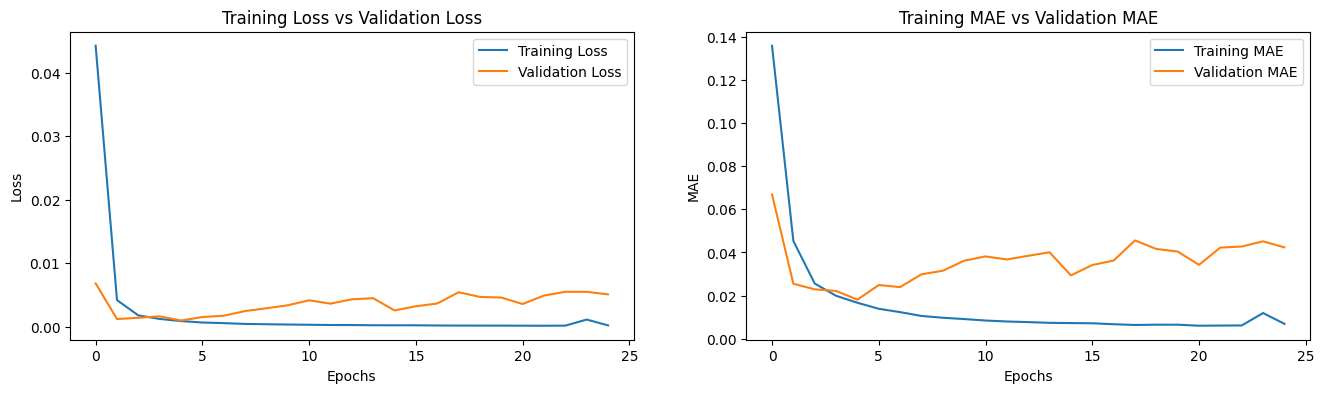

In [19]:
# Plot the training loss vs validation loss
plt.figure(figsize=(16, 4))

# Plot loss
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training Loss vs Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

# Plot MAE
plt.subplot(1, 2, 2)
plt.plot(history.history['mae'], label='Training MAE')
plt.plot(history.history['val_mae'], label='Validation MAE')
plt.title('Training MAE vs Validation MAE')
plt.xlabel('Epochs')
plt.ylabel('MAE')
plt.legend()

plt.show()


# Time Comparison

In [20]:
# Timing and memory usage measurement function
def measure_training_time_memory(model, x_train, y_train, epochs=50):
    start_time = time.time()
    mem_usage = memory_usage((model.fit, (x_train, y_train), {'epochs': epochs, 'batch_size': 32, 'validation_split': 0.2, 'callbacks': [tf.keras.callbacks.EarlyStopping(patience=5)]}), interval=0.1)
    end_time = time.time()
    training_time = end_time - start_time
    max_memory = max(mem_usage)
    return training_time, max_memory

In [21]:
# Prepare soft targets for soft distillation
temperature = 3
soft_targets = get_softened_outputs(teacher_model, X_train, temperature)
Y_train = Y_train.reshape(-1, 1)

# Prepare combined targets for soft distillation
y_combined = 0.5 * Y_train + 0.5 * soft_targets

# Measure performance of the teacher model
print("Teacher Model Performance:")
teacher_time, teacher_memory = measure_training_time_memory(teacher_model, X_train, Y_train)

# Measure performance of the student model (hard distillation)
print("Student Model Performance Using Hard Distillation:")
student_hard_time, student_hard_memory = measure_training_time_memory(student_model_hard, X_train, Y_train)

# Measure performance of the student model (soft distillation)
print("Student Model Performance Using Soft Distillation:")
student_soft_time, student_soft_memory = measure_training_time_memory(student_model_soft, X_train, y_combined)



469/469 [==============================] - 1s 2ms/step
Teacher Model Performance:


/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Epoch 1/50
375/375 [==============================] - 2s 5ms/step - loss: 1.8506e-04 - mae: 0.0072 - val_loss: 0.0067 - val_mae: 0.0502
Epoch 2/50
375/375 [==============================] - 2s 5ms/step - loss: 1.4758e-04 - mae: 0.0065 - val_loss: 0.0059 - val_mae: 0.0471
Epoch 3/50
375/375 [==============================] - 2s 4ms/step - loss: 1.4265e-04 - mae: 0.0063 - val_loss: 0.0064 - val_mae: 0.0496
Epoch 4/50
375/375 [==============================] - 2s 4ms/step - loss: 1.3547e-04 - mae: 0.0061 - val_loss: 0.0057 - val_mae: 0.0458
Epoch 5/50
375/375 [==============================] - 2s 4ms/step - loss: 1.3362e-04 - mae: 0.0060 - val_loss: 0.0074 - val_mae: 0.0539
Epoch 6/50
375/375 [==============================] - 2s 6ms/step - loss: 1.2474e-04 - mae: 0.0059 - val_loss: 0.0061 - val_mae: 0.0478
Epoch 7/50
375/375 [==============================] - 3s 7ms/step - loss: 1.1923e-04 - mae: 0.0059 - val_loss: 0.0053 - val_mae: 0.0449
Epoch 8/50
375/375 [============================

/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Student Model Performance Using Hard Distillation:


/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Epoch 1/50
375/375 [==============================] - 2s 4ms/step - loss: 0.0026 - mae: 0.0296 - val_loss: 0.0019 - val_mae: 0.0251
Epoch 2/50
375/375 [==============================] - 1s 4ms/step - loss: 0.0026 - mae: 0.0296 - val_loss: 0.0034 - val_mae: 0.0376
Epoch 3/50
375/375 [==============================] - 1s 3ms/step - loss: 0.0025 - mae: 0.0291 - val_loss: 0.0041 - val_mae: 0.0382
Epoch 4/50
375/375 [==============================] - 1s 2ms/step - loss: 0.0023 - mae: 0.0282 - val_loss: 0.0063 - val_mae: 0.0507
Epoch 5/50
375/375 [==============================] - 1s 2ms/step - loss: 0.0025 - mae: 0.0289 - val_loss: 0.0016 - val_mae: 0.0256
Epoch 6/50
375/375 [==============================] - 1s 2ms/step - loss: 0.0023 - mae: 0.0282 - val_loss: 0.0021 - val_mae: 0.0280
Epoch 7/50
375/375 [==============================] - 1s 3ms/step - loss: 0.0023 - mae: 0.0281 - val_loss: 0.0012 - val_mae: 0.0225
Epoch 8/50
375/375 [==============================] - 1s 2ms/step - loss: 0.

/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Student Model Performance Using Soft Distillation:
Epoch 1/50
  1/375 [..............................] - ETA: 4s - loss: 1.3990e-04 - mae: 0.0069

/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


375/375 [==============================] - 1s 3ms/step - loss: 9.8708e-04 - mae: 0.0160 - val_loss: 4.6032e-04 - val_mae: 0.0126
Epoch 2/50
375/375 [==============================] - 1s 4ms/step - loss: 9.1397e-04 - mae: 0.0151 - val_loss: 0.0021 - val_mae: 0.0283
Epoch 3/50
375/375 [==============================] - 2s 4ms/step - loss: 8.4532e-04 - mae: 0.0143 - val_loss: 8.7738e-04 - val_mae: 0.0181
Epoch 4/50
375/375 [==============================] - 2s 4ms/step - loss: 8.4796e-04 - mae: 0.0144 - val_loss: 0.0029 - val_mae: 0.0324
Epoch 5/50
375/375 [==============================] - 2s 4ms/step - loss: 8.0368e-04 - mae: 0.0141 - val_loss: 3.4717e-04 - val_mae: 0.0120
Epoch 6/50
375/375 [==============================] - 1s 4ms/step - loss: 8.6082e-04 - mae: 0.0147 - val_loss: 0.0031 - val_mae: 0.0332
Epoch 7/50
375/375 [==============================] - 1s 4ms/step - loss: 8.1458e-04 - mae: 0.0146 - val_loss: 4.0484e-04 - val_mae: 0.0120
Epoch 8/50
375/375 [=======================

In [22]:
print(f"Teacher Model - Training Time: {teacher_time} seconds, Memory Usage: {teacher_memory} MiB")
print(f"Student Model (Hard Distillation) - Training Time: {student_hard_time} seconds, Memory Usage: {student_hard_memory} MiB")
print(f"Student Model (Soft Distillation) - Training Time: {student_soft_time} seconds, Memory Usage: {student_soft_memory} MiB")

Teacher Model - Training Time: 25.97409749031067 seconds, Memory Usage: 1156.38671875 MiB
Student Model (Hard Distillation) - Training Time: 12.946775436401367 seconds, Memory Usage: 1156.40625 MiB
Student Model (Soft Distillation) - Training Time: 23.864230632781982 seconds, Memory Usage: 1156.4609375 MiB


# USA Data Import

In [23]:
# Define the file path for the Excel file stored in Google Drive
file_path = '/content/drive/MyDrive/DataSet_USA_3k_5k.xlsx'

# Use pandas to read the Excel file located at the specified file path
data = pd.read_excel(file_path)

In [24]:
# Display the first few rows of the dataframe to get an overview of the data
data.head()

,Power_1,Power_2,Power_3,Power_4,Power_5,Power_6,Power_7,Power_8,Power_9,Power_10,...,GSNR_72,GSNR_73,GSNR_74,GSNR_75,GSNR_76,Source,Destination,No. Spans,Total Distance(m),Number of ON channels
0,0.000000,0.000000,0.000096,0.000096,0.000096,0.000000,0.000096,0.0,0.000096,0.0,...,0.000000,0.000000,26.391513,0.000000,0.000000,trxHouston0,trxJacksonville58,23,2050305.0,26
1,0.000000,0.000096,0.000000,0.000096,0.000000,0.000096,0.000000,0.0,0.000000,0.0,...,0.000000,25.764675,0.000000,0.000000,0.000000,trxHouston0,trxJacksonville58,23,2050305.0,26
2,0.000000,0.000000,0.000000,0.000096,0.000000,0.000000,0.000000,0.0,0.000096,0.0,...,0.000000,0.000000,0.000000,24.616361,24.297057,trxHouston0,trxJacksonville58,23,2050305.0,26
3,0.000096,0.000096,0.000095,0.000095,0.000096,0.000000,0.000000,0.0,0.000096,0.0,...,22.810189,0.000000,0.000000,0.000000,0.000000,trxHouston0,trxJacksonville58,23,2050305.0,26
4,0.000000,0.000000,0.000096,0.000000,0.000096,0.000000,0.000000,0.0,0.000096,0.0,...,21.211149,21.131602,21.349516,22.572032,0.000000,trxHouston0,trxJacksonville58,23,2050305.0,26


### Normalization

In [25]:
# MinMax Normalization
# Initialize the MinMaxScaler
scaler = MinMaxScaler()

# Normalize the attribute columns using MinMaxScaler and convert the result back to a DataFrame
x = scaler.fit_transform(data[attribute_columns])
x = pd.DataFrame(x, columns=attribute_columns)

# Extract the target variable values and reshape them for normalization
y = data[target_column].values.reshape(-1, 1)
# Normalize the target variable using MinMaxScaler and convert the result back to a DataFrame
y = scaler.fit_transform(y)
y = pd.DataFrame(y, columns=[target_column])

# Display the first few rows of the normalized data for selected columns
print("MinMax Normalized Data:")
print(x['Power_1'].head(), x['ASE_1'].head(), x['NLI_1'].head(), x['No. Spans'].head(), x['Total Distance(m)'].head())
print(y.head())

MinMax Normalized Data:
0    0.000000
1    0.000000
2    0.000000
3    0.977579
4    0.000000
Name: Power_1, dtype: float64 0    1.000000
1    1.000000
2    1.000000
3    0.025744
4    1.000000
Name: ASE_1, dtype: float64 0    0.00000
1    0.00000
2    0.00000
3    0.37318
4    0.00000
Name: NLI_1, dtype: float64 0    0.392857
1    0.392857
2    0.392857
3    0.392857
4    0.392857
Name: No. Spans, dtype: float64 0    0.39403
1    0.39403
2    0.39403
3    0.39403
4    0.39403
Name: Total Distance(m), dtype: float64
     GSNR_1
0  0.000000
1  0.000000
2  0.000000
3  0.013061
4  0.000000


### Path Wise Split

In [26]:
# Assuming 'x' and 'y' are your DataFrames for MinMax normalized data
# Perform the custom train-test split on the normalized data
X_train, X_test, Y_train, Y_test = custom_train_test_split(x[attribute_columns], y[target_column])

# Display shapes to verify the split
print("Normalized data with equal path distribution in train and test data :\n")
print("Train data shape:", X_train.shape)
print("Test data shape:", X_test.shape)
print("Train labels shape:", Y_train.shape)
print("Test labels shape:", Y_test.shape)

Normalized data with equal path distribution in train and test data :

Train data shape: (30000, 230)
Test data shape: (6000, 230)
Train labels shape: (30000,)
Test labels shape: (6000,)


# Teacher Model

In [27]:
# Define a large teacher model architecture
teacher_model = Sequential([
    Dense(256, activation='relu', input_shape=(len(attribute_columns),)),  # First layer with 256 neurons
    Dropout(0.2),  # Add dropout for regularization
    Dense(128, activation='relu'),  # Second layer with 128 neurons
    Dropout(0.2),  # Add dropout for regularization
    Dense(64, activation='relu'),  # Third layer with 64 neurons
    Dropout(0.2),  # Add dropout for regularization
    Dense(32, activation='relu'),  # Fourth layer with 32 neurons
    Dense(16, activation='relu'),  # Fifth layer with 16 neurons
    Dense(1)  # Output layer for regression task
])

# Compile the model
teacher_model.compile(optimizer='adam', loss='mse', metrics=['mae'])

# Train the teacher model
history = teacher_model.fit(X_train, Y_train, epochs=25, batch_size=64, validation_split=0.2)  # Increase epochs for better training

# Evaluate the teacher model
val_loss, val_mae = teacher_model.evaluate(X_test, Y_test)
print(f"Validation MAE: {val_mae}")


Epoch 1/25
375/375 [==============================] - 4s 6ms/step - loss: 0.0288 - mae: 0.0621 - val_loss: 1.5997e-04 - val_mae: 0.0119
Epoch 2/25
375/375 [==============================] - 3s 8ms/step - loss: 0.0230 - mae: 0.0556 - val_loss: 1.1162e-04 - val_mae: 0.0101
Epoch 3/25
375/375 [==============================] - 3s 8ms/step - loss: 0.0108 - mae: 0.0342 - val_loss: 2.3637e-05 - val_mae: 0.0042
Epoch 4/25
375/375 [==============================] - 2s 6ms/step - loss: 9.1123e-04 - mae: 0.0117 - val_loss: 1.9200e-05 - val_mae: 0.0036
Epoch 5/25
375/375 [==============================] - 2s 5ms/step - loss: 5.8699e-04 - mae: 0.0102 - val_loss: 2.6618e-05 - val_mae: 0.0048
Epoch 6/25
375/375 [==============================] - 2s 6ms/step - loss: 5.1479e-04 - mae: 0.0098 - val_loss: 1.7254e-05 - val_mae: 0.0035
Epoch 7/25
375/375 [==============================] - 2s 5ms/step - loss: 3.9030e-04 - mae: 0.0091 - val_loss: 1.6959e-05 - val_mae: 0.0035
Epoch 8/25
375/375 [============

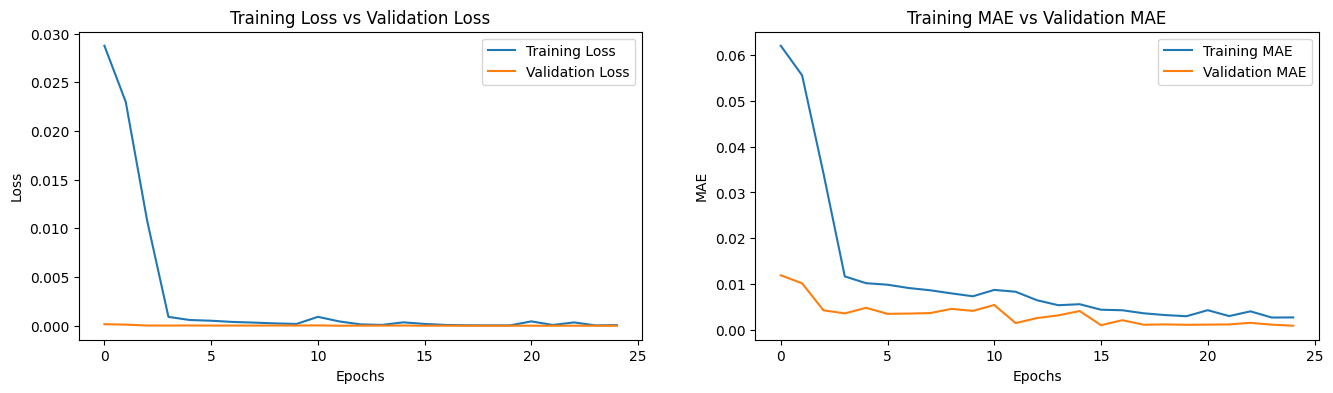

In [28]:
# Plot the training loss vs validation loss
plt.figure(figsize=(16, 4))

# Plot loss
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training Loss vs Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

# Plot MAE
plt.subplot(1, 2, 2)
plt.plot(history.history['mae'], label='Training MAE')
plt.plot(history.history['val_mae'], label='Validation MAE')
plt.title('Training MAE vs Validation MAE')
plt.xlabel('Epochs')
plt.ylabel('MAE')
plt.legend()

plt.show()


# Student Model

### Hard Distillation

In [29]:
# Define the student model architecture
student_model_hard = Sequential([
    Dense(64, activation='relu', input_shape=(len(attribute_columns),)),
    Dropout(0.2),
    Dense(32, activation='relu'),
    Dropout(0.2),
    Dense(1)
])

# Compile the student model
student_model_hard.compile(optimizer='adam', loss='mse', metrics=['mae'])

# Train the student model
history_hard = student_model_hard.fit(X_train, Y_train, epochs=25, batch_size=64, validation_split=0.2)  # Increase epochs for better training

# Evaluate the student model
val_loss_hard, val_mae_hard = student_model_hard.evaluate(X_test, Y_test)
print(f"Validation MAE (Hard Distillation): {val_mae_hard}")


Epoch 1/25
375/375 [==============================] - 3s 5ms/step - loss: 0.0414 - mae: 0.1017 - val_loss: 1.5839e-04 - val_mae: 0.0107
Epoch 2/25
375/375 [==============================] - 2s 5ms/step - loss: 0.0245 - mae: 0.0628 - val_loss: 6.1867e-05 - val_mae: 0.0067
Epoch 3/25
375/375 [==============================] - 2s 4ms/step - loss: 0.0242 - mae: 0.0588 - val_loss: 7.4294e-05 - val_mae: 0.0076
Epoch 4/25
375/375 [==============================] - 1s 4ms/step - loss: 0.0240 - mae: 0.0580 - val_loss: 5.4369e-05 - val_mae: 0.0064
Epoch 5/25
375/375 [==============================] - 1s 3ms/step - loss: 0.0237 - mae: 0.0572 - val_loss: 4.9054e-05 - val_mae: 0.0061
Epoch 6/25
375/375 [==============================] - 1s 2ms/step - loss: 0.0233 - mae: 0.0562 - val_loss: 2.4050e-05 - val_mae: 0.0036
Epoch 7/25
375/375 [==============================] - 1s 2ms/step - loss: 0.0225 - mae: 0.0550 - val_loss: 2.1778e-05 - val_mae: 0.0037
Epoch 8/25
375/375 [============================

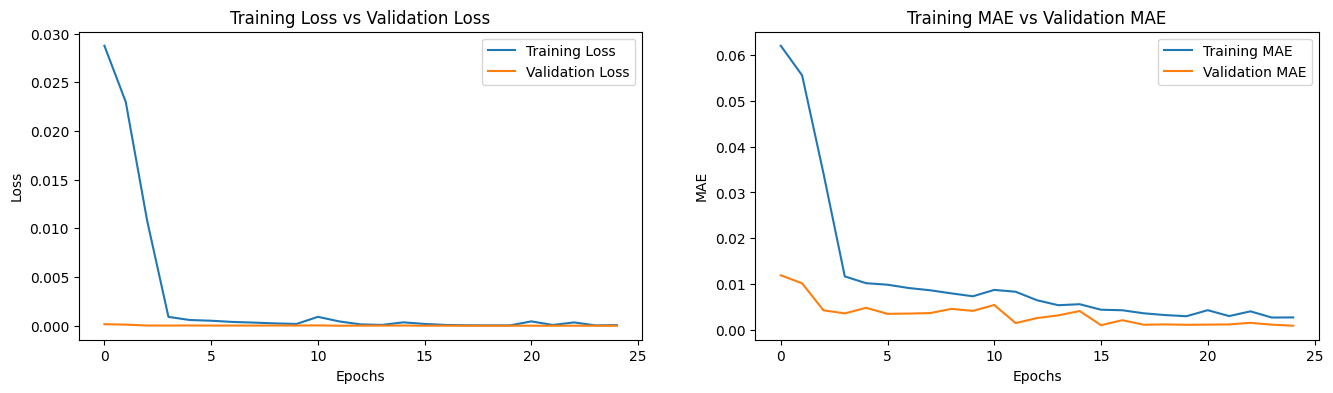

In [30]:
# Plot the training loss vs validation loss
plt.figure(figsize=(16, 4))

# Plot loss
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training Loss vs Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

# Plot MAE
plt.subplot(1, 2, 2)
plt.plot(history.history['mae'], label='Training MAE')
plt.plot(history.history['val_mae'], label='Validation MAE')
plt.title('Training MAE vs Validation MAE')
plt.xlabel('Epochs')
plt.ylabel('MAE')
plt.legend()

plt.show()


### Soft Distilaltion

In [31]:
def get_softened_outputs(model, data, temperature=1):
    logits = model.predict(data) / temperature
    exp_logits = np.exp(logits)
    return exp_logits / np.sum(exp_logits, axis=1, keepdims=True)

In [32]:
# Get softened outputs from the teacher model
temperature = 1
soft_targets = get_softened_outputs(teacher_model, X_train, temperature)

# Define the student model architecture
student_model_soft = Sequential([
    Dense(64, activation='relu', input_shape=(len(attribute_columns),)),
    Dropout(0.2),
    Dense(32, activation='relu'),
    Dropout(0.2),
    Dense(1)
])

# Compile the student model
student_model_soft.compile(optimizer='adam', loss='mse', metrics=['mae'])

# Train the student model using a combination of soft targets and ground truth labels
Y_train = Y_train.values.reshape(-1, 1)
y_combined = 0.5 * Y_train + 0.5 * soft_targets

history_soft = student_model_soft.fit(X_train, y_combined, epochs=25, batch_size=64, validation_split=0.2)  # Increase epochs for better training


# Evaluate the student model
val_loss_soft, val_mae_soft = student_model_soft.evaluate(X_test, Y_test)
print(f"Validation MAE (Soft Distillation): {val_mae_soft}")


938/938 [==============================] - 2s 2ms/step
Epoch 1/25
375/375 [==============================] - 3s 4ms/step - loss: 0.0515 - mae: 0.1565 - val_loss: 0.0043 - val_mae: 0.0571
Epoch 2/25
375/375 [==============================] - 1s 2ms/step - loss: 0.0140 - mae: 0.0866 - val_loss: 0.0018 - val_mae: 0.0375
Epoch 3/25
375/375 [==============================] - 1s 2ms/step - loss: 0.0098 - mae: 0.0670 - val_loss: 4.8388e-04 - val_mae: 0.0193
Epoch 4/25
375/375 [==============================] - 1s 2ms/step - loss: 0.0080 - mae: 0.0553 - val_loss: 1.4055e-04 - val_mae: 0.0101
Epoch 5/25
375/375 [==============================] - 1s 2ms/step - loss: 0.0071 - mae: 0.0471 - val_loss: 2.7722e-05 - val_mae: 0.0040
Epoch 6/25
375/375 [==============================] - 1s 2ms/step - loss: 0.0065 - mae: 0.0409 - val_loss: 2.6154e-05 - val_mae: 0.0038
Epoch 7/25
375/375 [==============================] - 1s 2ms/step - loss: 0.0062 - mae: 0.0359 - val_loss: 1.4757e-05 - val_mae: 0.0027
E

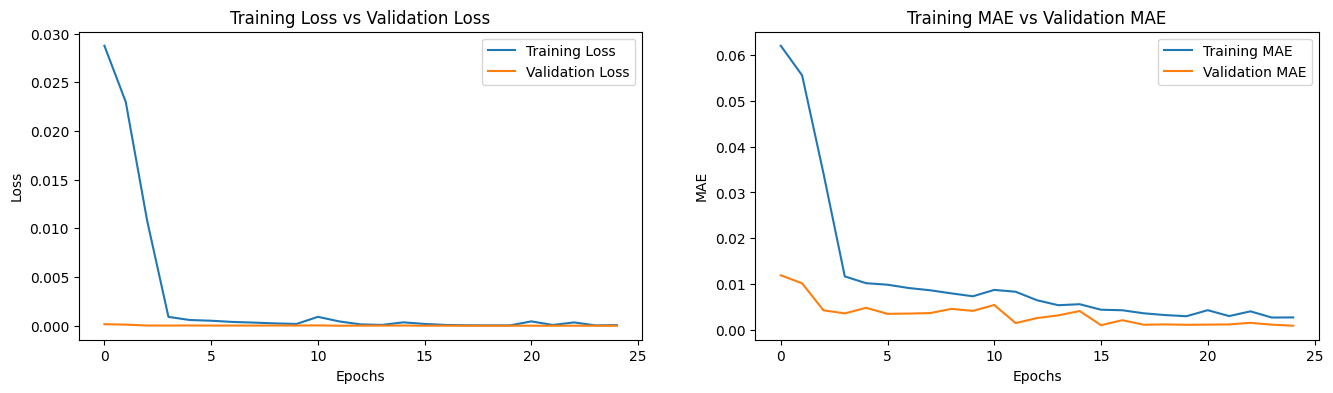

In [33]:
# Plot the training loss vs validation loss
plt.figure(figsize=(16, 4))

# Plot loss
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training Loss vs Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

# Plot MAE
plt.subplot(1, 2, 2)
plt.plot(history.history['mae'], label='Training MAE')
plt.plot(history.history['val_mae'], label='Validation MAE')
plt.title('Training MAE vs Validation MAE')
plt.xlabel('Epochs')
plt.ylabel('MAE')
plt.legend()

plt.show()


In [34]:
# Get softened outputs from the teacher model
temperature = 5
soft_targets = get_softened_outputs(teacher_model, X_train, temperature)

# Define the student model architecture
student_model_soft = Sequential([
    Dense(64, activation='relu', input_shape=(len(attribute_columns),)),
    Dropout(0.2),
    Dense(32, activation='relu'),
    Dropout(0.2),
    Dense(1)
])

# Compile the student model
student_model_soft.compile(optimizer='adam', loss='mse', metrics=['mae'])

# Train the student model using a combination of soft targets and ground truth labels
y_combined = 0.5 * Y_train + 0.5 * soft_targets

history_soft = student_model_soft.fit(X_train, y_combined, epochs=25, batch_size=64, validation_split=0.2)  # Increase epochs for better training


# Evaluate the student model
val_loss_soft, val_mae_soft = student_model_soft.evaluate(X_test, Y_test)
print(f"Validation MAE (Soft Distillation): {val_mae_soft}")


938/938 [==============================] - 2s 2ms/step
Epoch 1/25
375/375 [==============================] - 2s 3ms/step - loss: 0.0345 - mae: 0.1269 - val_loss: 0.0020 - val_mae: 0.0387
Epoch 2/25
375/375 [==============================] - 1s 2ms/step - loss: 0.0090 - mae: 0.0615 - val_loss: 8.2435e-05 - val_mae: 0.0060
Epoch 3/25
375/375 [==============================] - 1s 2ms/step - loss: 0.0076 - mae: 0.0509 - val_loss: 9.8323e-05 - val_mae: 0.0089
Epoch 4/25
375/375 [==============================] - 1s 2ms/step - loss: 0.0069 - mae: 0.0467 - val_loss: 6.4963e-05 - val_mae: 0.0071
Epoch 5/25
375/375 [==============================] - 1s 2ms/step - loss: 0.0066 - mae: 0.0431 - val_loss: 1.8067e-05 - val_mae: 0.0036
Epoch 6/25
375/375 [==============================] - 1s 3ms/step - loss: 0.0064 - mae: 0.0401 - val_loss: 1.4867e-05 - val_mae: 0.0033
Epoch 7/25
375/375 [==============================] - 1s 4ms/step - loss: 0.0062 - mae: 0.0368 - val_loss: 2.9159e-05 - val_mae: 0.00

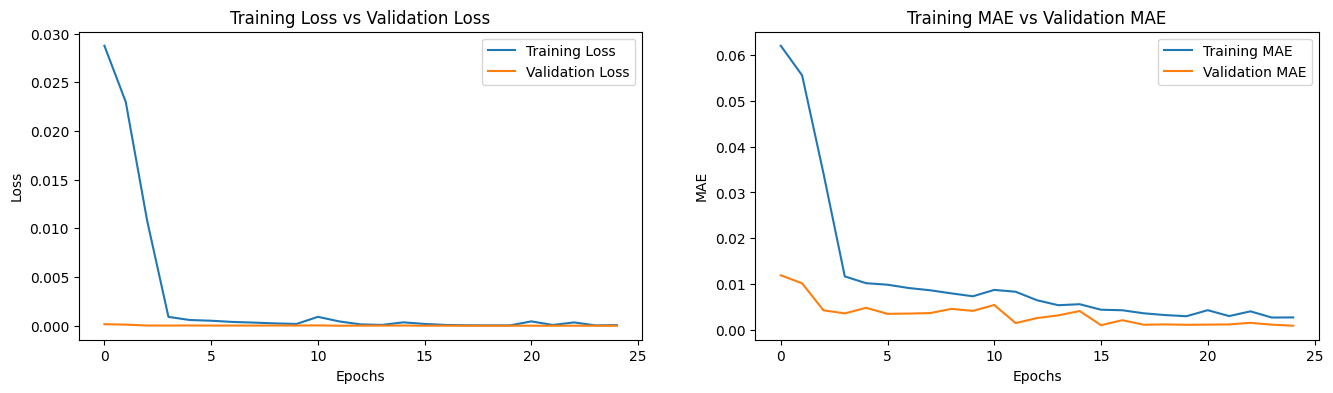

In [35]:
# Plot the training loss vs validation loss
plt.figure(figsize=(16, 4))

# Plot loss
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training Loss vs Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

# Plot MAE
plt.subplot(1, 2, 2)
plt.plot(history.history['mae'], label='Training MAE')
plt.plot(history.history['val_mae'], label='Validation MAE')
plt.title('Training MAE vs Validation MAE')
plt.xlabel('Epochs')
plt.ylabel('MAE')
plt.legend()

plt.show()


In [36]:
# Get softened outputs from the teacher model
temperature = 10
soft_targets = get_softened_outputs(teacher_model, X_train, temperature)

# Define the student model architecture
student_model_soft = Sequential([
    Dense(64, activation='relu', input_shape=(len(attribute_columns),)),
    Dropout(0.2),
    Dense(32, activation='relu'),
    Dropout(0.2),
    Dense(1)
])

# Compile the student model
student_model_soft.compile(optimizer='adam', loss='mse', metrics=['mae'])

# Train the student model using a combination of soft targets and ground truth labels
y_combined = 0.5 * Y_train + 0.5 * soft_targets

history_soft = student_model_soft.fit(X_train, y_combined, epochs=25, batch_size=64, validation_split=0.2)  # Increase epochs for better training


# Evaluate the student model
val_loss_soft, val_mae_soft = student_model_soft.evaluate(X_test, Y_test)
print(f"Validation MAE (Soft Distillation): {val_mae_soft}")


938/938 [==============================] - 2s 2ms/step
Epoch 1/25
375/375 [==============================] - 2s 3ms/step - loss: 0.0408 - mae: 0.1352 - val_loss: 8.8326e-04 - val_mae: 0.0232
Epoch 2/25
375/375 [==============================] - 1s 2ms/step - loss: 0.0091 - mae: 0.0612 - val_loss: 7.5434e-05 - val_mae: 0.0056
Epoch 3/25
375/375 [==============================] - 1s 2ms/step - loss: 0.0079 - mae: 0.0533 - val_loss: 5.4753e-05 - val_mae: 0.0063
Epoch 4/25
375/375 [==============================] - 1s 3ms/step - loss: 0.0073 - mae: 0.0493 - val_loss: 2.0130e-05 - val_mae: 0.0030
Epoch 5/25
375/375 [==============================] - 1s 4ms/step - loss: 0.0069 - mae: 0.0456 - val_loss: 2.2503e-05 - val_mae: 0.0040
Epoch 6/25
375/375 [==============================] - 1s 4ms/step - loss: 0.0067 - mae: 0.0420 - val_loss: 2.0109e-05 - val_mae: 0.0027
Epoch 7/25
375/375 [==============================] - 1s 3ms/step - loss: 0.0065 - mae: 0.0390 - val_loss: 4.8766e-05 - val_mae: 

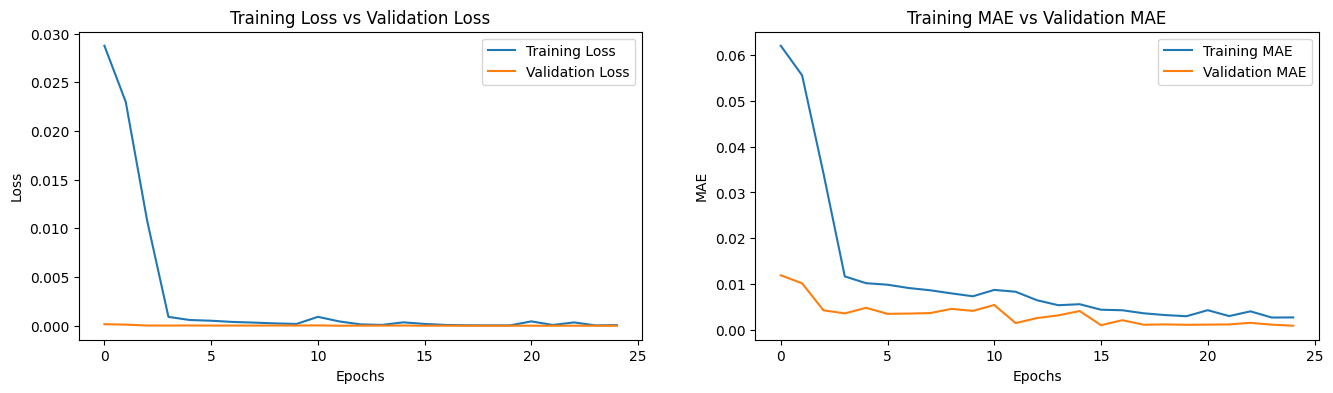

In [37]:
# Plot the training loss vs validation loss
plt.figure(figsize=(16, 4))

# Plot loss
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training Loss vs Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

# Plot MAE
plt.subplot(1, 2, 2)
plt.plot(history.history['mae'], label='Training MAE')
plt.plot(history.history['val_mae'], label='Validation MAE')
plt.title('Training MAE vs Validation MAE')
plt.xlabel('Epochs')
plt.ylabel('MAE')
plt.legend()

plt.show()


# Time Comparison

In [38]:
# Prepare soft targets for soft distillation
temperature = 3
soft_targets = get_softened_outputs(teacher_model, X_train, temperature)

# Prepare combined targets for soft distillation
y_combined = 0.5 * Y_train + 0.5 * soft_targets

# Measure performance of the teacher model
print("Teacher Model Performance:")
teacher_time, teacher_memory = measure_training_time_memory(teacher_model, X_train, Y_train)

# Measure performance of the student model (hard distillation)
print("Student Model Performance Using Hard Distillation:")
student_hard_time, student_hard_memory = measure_training_time_memory(student_model_hard, X_train, Y_train)

# Measure performance of the student model (soft distillation)
print("Student Model Performance Using Soft Distillation:")
student_soft_time, student_soft_memory = measure_training_time_memory(student_model_soft, X_train, y_combined)



938/938 [==============================] - 2s 2ms/step
Teacher Model Performance:


/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Epoch 1/50
750/750 [==============================] - 6s 6ms/step - loss: 3.5588e-04 - mae: 0.0041 - val_loss: 1.3048e-06 - val_mae: 9.1789e-04
Epoch 2/50
750/750 [==============================] - 3s 4ms/step - loss: 3.3767e-04 - mae: 0.0036 - val_loss: 3.1335e-06 - val_mae: 0.0012
Epoch 3/50
750/750 [==============================] - 3s 4ms/step - loss: 3.9870e-05 - mae: 0.0027 - val_loss: 5.0112e-06 - val_mae: 0.0021
Epoch 4/50
750/750 [==============================] - 3s 4ms/step - loss: 7.1332e-05 - mae: 0.0026 - val_loss: 1.7989e-06 - val_mae: 9.4601e-04
Epoch 5/50
750/750 [==============================] - 5s 6ms/step - loss: 7.3967e-05 - mae: 0.0026 - val_loss: 1.0624e-06 - val_mae: 7.3553e-04
Epoch 6/50
750/750 [==============================] - 3s 5ms/step - loss: 3.9512e-05 - mae: 0.0027 - val_loss: 2.2464e-06 - val_mae: 8.0870e-04
Epoch 7/50
750/750 [==============================] - 3s 4ms/step - loss: 3.1707e-04 - mae: 0.0037 - val_loss: 5.7932e-06 - val_mae: 0.0018
Epoc

/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Student Model Performance Using Hard Distillation:


/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Epoch 1/50
750/750 [==============================] - 2s 3ms/step - loss: 0.0016 - mae: 0.0140 - val_loss: 1.7093e-05 - val_mae: 0.0038
Epoch 2/50
750/750 [==============================] - 2s 2ms/step - loss: 0.0015 - mae: 0.0133 - val_loss: 2.7330e-05 - val_mae: 0.0047
Epoch 3/50
750/750 [==============================] - 2s 2ms/step - loss: 0.0014 - mae: 0.0130 - val_loss: 4.5185e-05 - val_mae: 0.0065
Epoch 4/50
750/750 [==============================] - 2s 2ms/step - loss: 0.0014 - mae: 0.0129 - val_loss: 3.8701e-05 - val_mae: 0.0060
Epoch 5/50
750/750 [==============================] - 2s 3ms/step - loss: 0.0015 - mae: 0.0131 - val_loss: 3.4003e-05 - val_mae: 0.0055
Epoch 6/50
750/750 [==============================] - 3s 4ms/step - loss: 0.0014 - mae: 0.0130 - val_loss: 3.2556e-05 - val_mae: 0.0055


/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Student Model Performance Using Soft Distillation:


/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Epoch 1/50
750/750 [==============================] - 2s 2ms/step - loss: 6.1590e-04 - mae: 0.0090 - val_loss: 1.6972e-05 - val_mae: 0.0037
Epoch 2/50
750/750 [==============================] - 2s 3ms/step - loss: 6.0581e-04 - mae: 0.0089 - val_loss: 1.2310e-05 - val_mae: 0.0027
Epoch 3/50
750/750 [==============================] - 3s 4ms/step - loss: 5.5251e-04 - mae: 0.0087 - val_loss: 1.2069e-05 - val_mae: 0.0029
Epoch 4/50
750/750 [==============================] - 3s 4ms/step - loss: 5.3066e-04 - mae: 0.0086 - val_loss: 3.5127e-05 - val_mae: 0.0036
Epoch 5/50
750/750 [==============================] - 3s 4ms/step - loss: 5.3806e-04 - mae: 0.0086 - val_loss: 1.2006e-05 - val_mae: 0.0028
Epoch 6/50
750/750 [==============================] - 2s 3ms/step - loss: 4.7978e-04 - mae: 0.0082 - val_loss: 1.1975e-05 - val_mae: 0.0027
Epoch 7/50
750/750 [==============================] - 2s 2ms/step - loss: 5.2598e-04 - mae: 0.0084 - val_loss: 1.1538e-04 - val_mae: 0.0040
Epoch 8/50
750/750 [

In [39]:
print(f"Teacher Model - Training Time: {teacher_time} seconds, Memory Usage: {teacher_memory} MiB")
print(f"Student Model (Hard Distillation) - Training Time: {student_hard_time} seconds, Memory Usage: {student_hard_memory} MiB")
print(f"Student Model (Soft Distillation) - Training Time: {student_soft_time} seconds, Memory Usage: {student_soft_memory} MiB")

Teacher Model - Training Time: 52.504470348358154 seconds, Memory Usage: 2162.265625 MiB
Student Model (Hard Distillation) - Training Time: 13.805224418640137 seconds, Memory Usage: 2204.49609375 MiB
Student Model (Soft Distillation) - Training Time: 39.276132106781006 seconds, Memory Usage: 2246.6171875 MiB


# Conclusion

**Note :**

For fair comparison epochs are kept constant.

**Learnings :**

1) Teacher Model as in normal model takes longer to for inference. The larger the dataset or the model architecture the more evident is the time.

2) For student model Hard Distillation and Soft Distilaltion takes relatively similar times.

If we consider the time taken to calculate soft labels then the overall time for soft distillation is more as it requires an additional step.

3) In terms of accuracy the teacher model is most accurate as expected while the Hard Distillation as it utilizes the actual lables is second most accurate.

4) Soft Distillation is the least accurate.

5) The temperature values acts as the smoothing parameter for the output distribution.


*   
T=1 ; The soft lable calculation function becomes softmax function.
*   T>1 ; Smooths the actual label distribution while the accuracy decreases with higher values of T.

6) The hard distillation model training becomes same as the teacher model training if the model architectures are the same. The key difference is the utilization of the teacher model predictions in student model to gain insights.







